In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
from datetime import datetime
import darts as dt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
(Stepwise ,
sklearn_selected ,
sklearn_selection_path)
from l0bnb import fit_path

# Loading the dataset

In [2]:
stocklist = []
stocknames = []

# LASSO Model Building

## Loading Dataset

In [3]:
Hitters = pd.read_csv('asx99.csv')
np.isnan(Hitters).sum()

Date    0
ABC     0
AGL     0
AIO     0
ALL     0
       ..
WBC     0
WES     0
WFD     0
WOW     0
WPL     0
Length: 100, dtype: int64

In [4]:
Hitters = Hitters.dropna ();
Hitters.shape
Hitters = Hitters.drop("Date", axis = 1)

In [5]:
def nCp(sigma2 , estimator , X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [6]:
design = MS(Hitters.columns.drop('ABC')).fit(Hitters)
Y = np.array(Hitters['ABC'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

In [8]:
neg_Cp = partial(nCp , sigma2)

In [9]:
strategy = Stepwise.first_peak(design ,
direction='forward',
max_terms=len(design.terms))

In [10]:
strategy = Stepwise.fixed_steps(design ,
len(design.terms),
direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

In [11]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(253, 99)

In [12]:
K = 5
kfold = skm.KFold(K,
random_state=0,
shuffle=True)

In [ ]:
D = design.fit_transform(Hitters)

In [14]:
D = D.drop(['intercept'], axis=1)
X = np.asarray(D)

In [15]:
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]
lambdas = 10**np.linspace(5, -5, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
Y,
l1_ratio=0.,
alphas=lambdas)[1]
soln_array.shape

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031182552081310815, tolerance: 6.236525149920506e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: U

(98, 100)

In [16]:
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AGL,AIO,ALL,ALQ,AMC,AMP,ANN,ANZ,APA,AST,...,TPM,TTS,TWE,VCX,VOC,WBC,WES,WFD,WOW,WPL
negative log(lambda),,,,,,,,,,,,,,,,,,,,,
-15.669291,1.099512e-09,6.716615e-10,9.711023e-10,6.939732e-10,1.047421e-09,1.327402e-09,6.818069e-10,1.231882e-09,1.021101e-09,8.392259e-10,...,5.929390e-10,1.092543e-09,8.245693e-10,4.339716e-10,6.454024e-10,1.320676e-09,1.151003e-09,1.102346e-09,7.886026e-10,1.016394e-09
-15.436706,1.387425e-09,8.475397e-10,1.225390e-09,8.756940e-10,1.321694e-09,1.674990e-09,8.603417e-10,1.554456e-09,1.288482e-09,1.058981e-09,...,7.482029e-10,1.378631e-09,1.040487e-09,5.476093e-10,8.144042e-10,1.666502e-09,1.452399e-09,1.391001e-09,9.951021e-10,1.282543e-09
-15.204122,1.750729e-09,1.069472e-09,1.546264e-09,1.104999e-09,1.667786e-09,2.113593e-09,1.085626e-09,1.961498e-09,1.625876e-09,1.336280e-09,...,9.441231e-10,1.739632e-09,1.312943e-09,6.910032e-10,1.027660e-09,2.102883e-09,1.832717e-09,1.755241e-09,1.255674e-09,1.618382e-09
-14.971537,2.209165e-09,1.349518e-09,1.951159e-09,1.394348e-09,2.104502e-09,2.667046e-09,1.369903e-09,2.475124e-09,2.051618e-09,1.686189e-09,...,1.191345e-09,2.195162e-09,1.656742e-09,8.719451e-10,1.296756e-09,2.653531e-09,2.312621e-09,2.214857e-09,1.584477e-09,2.042162e-09
-14.738953,2.787642e-09,1.702895e-09,2.462077e-09,1.759465e-09,2.655573e-09,3.365421e-09,1.728617e-09,3.123243e-09,2.588841e-09,2.127722e-09,...,1.503302e-09,2.769972e-09,2.090565e-09,1.100267e-09,1.636316e-09,3.348367e-09,2.918189e-09,2.794825e-09,1.999377e-09,2.576909e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6.426223,1.108977e-03,2.560494e-03,-4.119649e-04,4.610167e-04,1.916184e-04,-1.937657e-03,1.943632e-03,4.246423e-04,6.507844e-04,-2.141589e-03,...,-2.078432e-03,1.355828e-03,-1.856429e-04,5.499704e-04,9.952531e-04,1.168467e-04,6.592250e-04,-6.462282e-05,-1.322176e-03,5.722331e-04
6.658807,1.111451e-03,2.564365e-03,-4.121744e-04,4.591353e-04,1.935398e-04,-1.945711e-03,1.947387e-03,4.246063e-04,6.516093e-04,-2.144472e-03,...,-2.082275e-03,1.357456e-03,-1.853011e-04,5.501701e-04,9.988108e-04,1.178374e-04,6.609638e-04,-6.127459e-05,-1.324180e-03,5.745331e-04
6.891392,1.113418e-03,2.567445e-03,-4.123413e-04,4.576323e-04,1.950749e-04,-1.952144e-03,1.950379e-03,4.245743e-04,6.522662e-04,-2.146769e-03,...,-2.085337e-03,1.358747e-03,-1.850275e-04,5.503237e-04,1.001650e-03,1.186359e-04,6.623559e-04,-5.858578e-05,-1.325777e-03,5.763673e-04


Text(0, 0.5, 'Standardized coefficients')

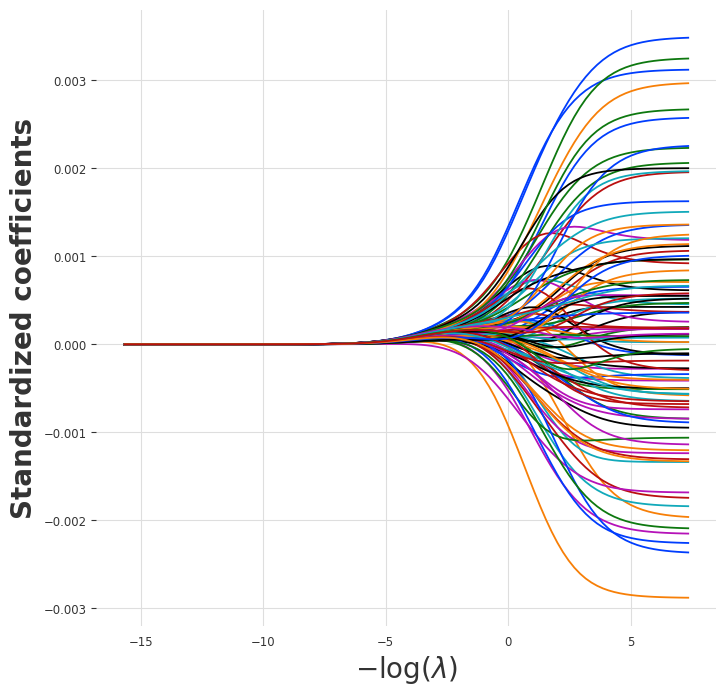

In [17]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
#ax.legend(loc='upper left')

In [18]:
soln_array

array([[ 1.09951241e-09,  1.38742536e-09,  1.75072914e-09, ...,
         1.11341839e-03,  1.11498140e-03,  1.11622260e-03],
       [ 6.71661475e-10,  8.47539673e-10,  1.06947221e-09, ...,
         2.56744535e-03,  2.56989460e-03,  2.57184072e-03],
       [ 9.71102273e-10,  1.22539025e-09,  1.54626418e-09, ...,
        -4.12341257e-04, -4.12473986e-04, -4.12579501e-04],
       ...,
       [ 1.10234582e-09,  1.39100068e-09,  1.75524065e-09, ...,
        -5.85857754e-05, -5.64323953e-05, -5.47115614e-05],
       [ 7.88602589e-10,  9.95102064e-10,  1.25567394e-09, ...,
        -1.32577680e-03, -1.32704679e-03, -1.32805637e-03],
       [ 1.01639442e-09,  1.28254250e-09,  1.61838225e-09, ...,
         5.76367335e-04,  5.77828234e-04,  5.78990578e-04]])

In [19]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(733.993936152688,
 AGL    0.000009
 AIO    0.000006
 ALL    0.000008
 ALQ    0.000006
 AMC    0.000009
          ...   
 WBC    0.000011
 WES    0.000010
 WFD    0.000009
 WOW    0.000007
 WPL    0.000008
 Name: -6.598500767208031, Length: 98, dtype: float64)

In [20]:
np.linalg.norm(beta_hat)

7.943492892752979e-05

In [21]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(7.006327789536935, 0.0017002893571431313)

In [22]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-02, tolerance: 6.208e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=7.006327789536935, l1_ratio=0))])

In [23]:
np.linalg.norm(ridge.coef_)

0.0017002893571431302

In [24]:
validation = skm.ShuffleSplit(n_splits=1,
test_size=0.5,
random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge ,
X,
Y,
scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-02, tolerance: 3.523e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.00013883])

In [25]:
ridge.alpha = 1e10
results = skm.cross_validate(ridge ,
X,
Y,
scoring='neg_mean_squared_error',
cv=validation)
-results['test_score']

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-02, tolerance: 3.523e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([0.00021302])

In [26]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe ,
param_grid ,
cv=validation ,
scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-02, tolerance: 3.523e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=4.400178045531427, l1_ratio=0))])

In [27]:
print(grid.best_params_['ridge__alpha'])
print(grid.best_estimator_)

4.400178045531427
Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=4.400178045531427, l1_ratio=0))])


In [28]:
grid = skm.GridSearchCV(pipe ,
param_grid ,
cv=kfold ,
scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e-02, tolerance: 4.787e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=1.7355208909789597, l1_ratio=0))])

Text(0, 0.5, 'Cross -validated MSE')

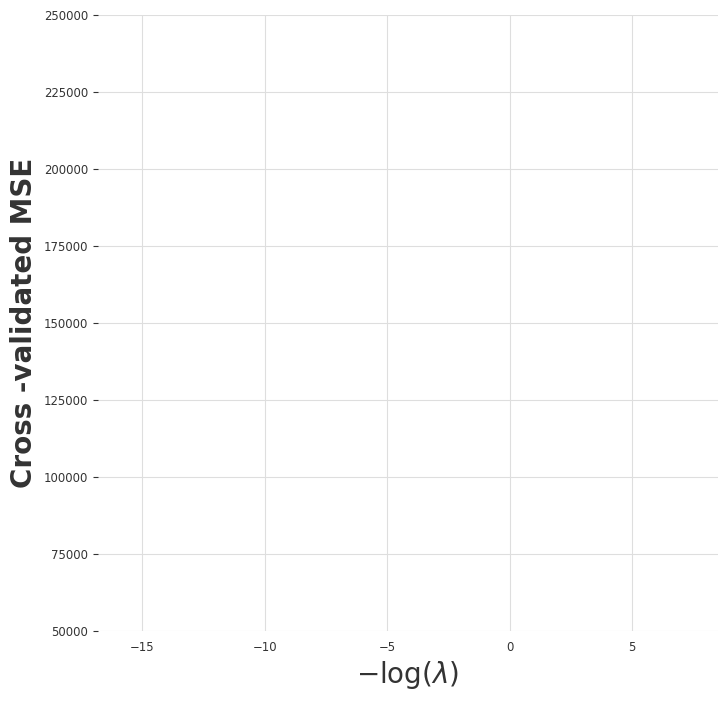

In [29]:
ridge_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [30]:
grid_r2 = skm.GridSearchCV(pipe ,
param_grid ,
cv=kfold)
grid_r2.fit(X, Y)

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.393e-02, tolerance: 4.787e-06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisat

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([6.38390494e+06, 5.05913549e+06, 4.00927836e+06, 3.17728453e+06,
       2.51794365e+06, 1.99542729e+06, 1.58134200e+06, 1.25318649e+06,
       9.93128862e+05, 7.87037639...
       1.34375080e-01, 1.06489953e-01, 8.43914663e-02, 6.68787938e-02,
       5.30003003e-02, 4.20018316e-02, 3.32857333e-02, 2.63783744e-02,
       2.09044106e-02, 1.65663879e-02, 1.31285791e-02, 1.04041744e-02,
       8.24513029e-03, 6.53412475e-03, 5.17818212e-03, 4.10362077e-03,
       3.25204928e-03, 2.57719344e-03, 2.04238173e-03, 1.61855259e-03,
       1.28267525e-03, 1.01649820e-03, 8.05557439e-04, 6.38390494e-04])})

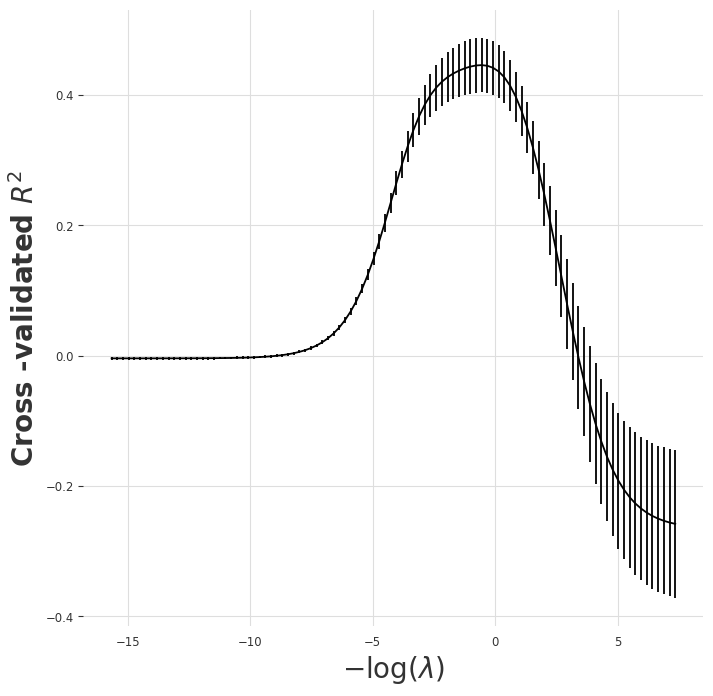

In [31]:
r2_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
grid_r2.cv_results_['mean_test_score'],
yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated $R^2$', fontsize=20);

In [32]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
l1_ratio=0,
cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),('ridge', ridgeCV)])
pipeCV.fit(X, Y)

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02393245173098661, tolerance: 4.786501763249334e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: Us

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([6.38390494e+06, 5.05913549e+06, 4.00927836e+06, 3.17728453e+06,
       2.51794365e+06, 1.99542729e+06, 1.58134200e+06, 1.25318649e+06,
       9.93128862e+05, 7.87037639e+05, 6.23713869e+05, 4.94282575e+05,
       3.91710487e+05, 3.10423862e+05, 2.46005602e+05, 1.94955233e+05,
       1.54498688e+05, 1.22437568e+05,...
       5.30003003e-02, 4.20018316e-02, 3.32857333e-02, 2.63783744e-02,
       2.09044106e-02, 1.65663879e-02, 1.31285791e-02, 1.04041744e-02,
       8.24513029e-03, 6.53412475e-03, 5.17818212e-03, 4.10362077e-03,
       3.25204928e-03, 2.57719344e-03, 2.04238173e-03, 1.61855259e-03,
       1.28267525e-03, 1.01649820e-03, 8.05557439e-04, 6.38390494e-04]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

Text(0, 0.5, 'Cross -validated MSE')

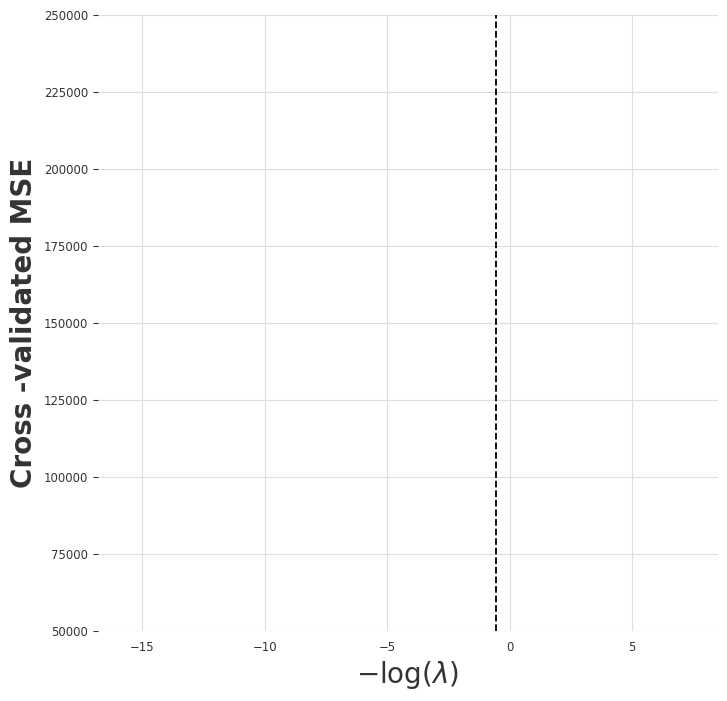

In [ ]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim ([0,0.1])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20)

In [34]:
np.min(tuned_ridge.mse_path_.mean(1))

0.00013592916597410576

In [35]:
tuned_ridge.coef_

array([ 2.23106373e-04,  4.55642632e-04,  8.00561671e-07,  4.74269973e-04,
        1.29493773e-04,  1.20554226e-04,  3.70282753e-04,  1.45970478e-04,
        1.21610308e-04, -3.09171538e-04, -2.86780062e-05,  5.68106408e-05,
       -1.13490310e-04,  2.99357890e-04,  9.93250879e-05,  1.00693138e-03,
        6.53438293e-05,  1.06233140e-04,  7.20517630e-04, -5.93169181e-04,
        2.46507003e-04, -9.67544751e-05,  2.47772348e-04,  1.23297880e-04,
       -1.42837122e-04,  5.20003847e-04,  1.46155879e-04,  7.30075568e-04,
        5.32720483e-04, -7.26380264e-05,  5.68408405e-04,  4.21630681e-05,
        1.56871413e-04,  1.85425710e-04,  4.66391042e-05,  8.43716517e-05,
        2.56672084e-04,  5.17284229e-04,  3.57738963e-04,  4.09727162e-04,
        2.03431350e-04, -1.47796806e-04,  2.93817265e-04,  4.92956324e-04,
        1.87856304e-04,  2.61833504e-04,  3.35496253e-04,  2.36746200e-04,
        4.71646630e-04,  4.24038191e-04,  9.64337745e-04, -1.04731699e-04,
        2.97957597e-04,  

In [36]:
outer_valid = skm.ShuffleSplit(n_splits=1,
test_size=0.25,
random_state=1)
inner_cv = skm.KFold(n_splits=5,
shuffle=True ,
random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas ,
l1_ratio=0,
cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
('ridge', ridgeCV)])
results = skm.cross_validate(pipeCV ,
X,
Y,
cv=outer_valid ,
scoring='neg_mean_squared_error')
-results['test_score']

c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017142944107767313, tolerance: 3.4285946487051483e-06
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mudit.000\OneDrive - University of Essex\Documents\GitHub\Personal-Research-Learning\Personal-Research-Learning\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: 

array([7.89412362e-05])

In [37]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
l1_ratio=1,
cv=kfold)   
pipeCV = Pipeline(steps=[('scaler', scaler),
('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.0009151088036707827

In [38]:
lambdas , soln_array = skl.Lasso.path(Xs,
Y,
l1_ratio=1,
n_alphas =100)[:2]
soln_path = pd.DataFrame(soln_array.T,
columns=D.columns ,
index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficiients')

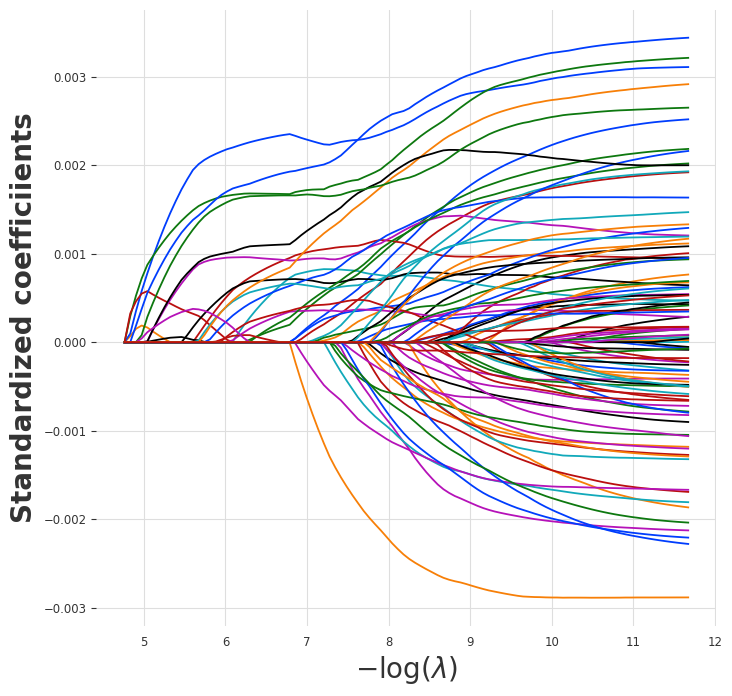

In [39]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
#ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20)

In [40]:
np.min(tuned_lasso.mse_path_.mean(1))

0.00013348720358094548

Text(0, 0.5, 'Cross -validated MSE')

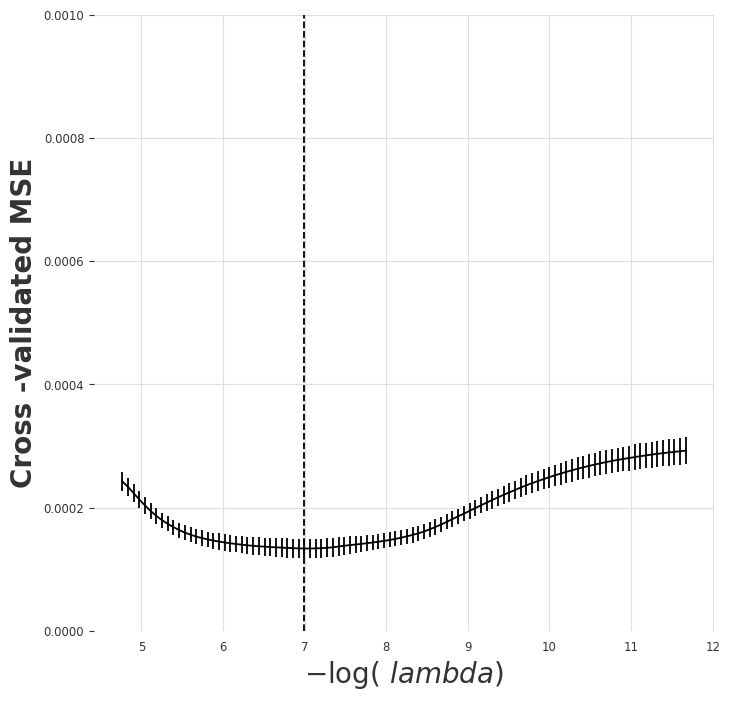

In [41]:
lassoCV_fig , ax = subplots(figsize =(8 ,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean (1),
yerr = tuned_lasso.mse_path_.std (1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([0 ,0.001])
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Cross -validated MSE', fontsize =20)

In [42]:
tuned_lasso.mse_path_.mean (1)

array([0.0002425 , 0.00023364, 0.00022339, 0.0002132 , 0.00020334,
       0.00019432, 0.00018637, 0.00017942, 0.00017347, 0.00016817,
       0.00016343, 0.00015936, 0.00015587, 0.0001529 , 0.0001504 ,
       0.00014824, 0.0001464 , 0.00014473, 0.00014324, 0.00014194,
       0.00014078, 0.00013969, 0.00013867, 0.00013781, 0.00013706,
       0.00013643, 0.00013588, 0.00013538, 0.00013488, 0.00013449,
       0.00013401, 0.00013369, 0.00013349, 0.0001335 , 0.00013368,
       0.00013404, 0.0001347 , 0.00013546, 0.00013667, 0.00013795,
       0.00013898, 0.00013998, 0.00014097, 0.00014207, 0.00014325,
       0.00014449, 0.00014579, 0.00014737, 0.00014902, 0.00015111,
       0.00015326, 0.00015552, 0.00015808, 0.0001611 , 0.00016456,
       0.0001683 , 0.00017238, 0.00017673, 0.0001812 , 0.00018565,
       0.00019004, 0.00019447, 0.00019896, 0.00020349, 0.00020792,
       0.00021229, 0.00021647, 0.0002206 , 0.00022457, 0.00022854,
       0.00023246, 0.00023615, 0.00023961, 0.00024294, 0.00024

In [43]:
-np.log(tuned_lasso.alpha_)

6.99646758864251